In [86]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# About

__Author:__ Pat McCornack

__Date:__ 02/14/25

__Description:__  
This notebook preprocesses the data and does basic qc checks. This includes subsetting the variables, renaming the variables to a standard format, and taking the action specified in the finding summary. 

__Findings Summary:__  
The highest number of fog tips is 1. It's possible the site simply doesn't receive fog.

__Outputs:__  
Cleaned data is output to `./data/02-clean/`

## Data QC 

In [87]:
#### Specify Arguments ###
fname = 'sci-crat.csv'
root_dir = Path().resolve().parents[1]
data_dir = root_dir / 'data'
src_fpath = data_dir / '01-raw' / 'met-station' / fname

outfpath = data_dir / '02-clean' / f'{str(fname).split('.')[0]}-clean.csv'
outfpath

# Define variables
var_dict = {
    'time (PST)' : 'datetime',
    'fog' : 'Fog',
    'air temperature (C)' : 'Temp',
    'relative humidity (%)' : 'RH',
    'wind speed (m/s)' : 'WindSpd',
    'wind gust (m/s)' : 'GustSpd',
    'wind direction (deg)' : 'WindDir',
    'rain (mm)' : 'Rain',
    'par (micromol/m2/s)' :'Par',
    'dew point (C)' : 'DewPt',
    'leaf wetness' : 'LeafWet',  # Unsure what the units are on this
    'soil moisture' : 'SoilMoist'  # I think this is VWC
}

# Fog tip value
fog_tip_v = 0.2

In [88]:
#### Read in and prepare data ####
df = pd.read_csv(src_fpath)

# Create timestamp
dates = [date.split(' ')[0] for date in df['Date']]
times = [time.split(' ')[1] for time in df['PST']]
df['datetime'] = [date + ' ' + time for date, time in zip(dates, times)]
df.head()

# Subset and rename columns
df = df[list(var_dict.values())]
df.columns = list(var_dict.keys())
df['time (PST)'] = pd.to_datetime(df['time (PST)'])

# Replace 'bad' value with NaN
df.replace(-888.888000, np.nan, inplace=True)
df.replace(-888.000000, np.nan, inplace=True)  # Dew point NaN

# Round fog values to closest .2
df['fog'] = df['fog'].round(1)
# Create fog tip var
df['fog tips'] = df['fog'] / fog_tip_v

/var/folders/77/txzkwfd92_q42s0qflv4nbh00000gn/T/ipykernel_31570/2764166389.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time (PST)'] = pd.to_datetime(df['time (PST)'])


### Missing Values
Observations:
1. Large chunks of data are missing - we won't be able to interpolate these values. 
2. Also noticed that NaN seems to be coded as -888.88
3. Wind data has same number of 'good' values as fog - it's filled with 0s during periods where data is missing for the other columns. 

Actions: 
1. Drop the missing fog observations, leave the smaller number of additional missing air temperature and relative humidity.

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89590 entries, 0 to 89589
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time (PST)             89590 non-null  datetime64[ns]
 1   fog                    15465 non-null  float64       
 2   air temperature (C)    25182 non-null  float64       
 3   relative humidity (%)  25182 non-null  float64       
 4   wind speed (m/s)       69131 non-null  float64       
 5   wind gust (m/s)        69131 non-null  float64       
 6   wind direction (deg)   69131 non-null  float64       
 7   rain (mm)              15465 non-null  float64       
 8   par (micromol/m2/s)    15465 non-null  float64       
 9   dew point (C)          25182 non-null  float64       
 10  leaf wetness           15465 non-null  float64       
 11  soil moisture          15465 non-null  float64       
 12  fog tips               15465 non-null  float64       
dtypes

In [90]:
# Drop missing observations
df = df.dropna(subset=['fog'])

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15465 entries, 3 to 15467
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time (PST)             15465 non-null  datetime64[ns]
 1   fog                    15465 non-null  float64       
 2   air temperature (C)    13168 non-null  float64       
 3   relative humidity (%)  13168 non-null  float64       
 4   wind speed (m/s)       7020 non-null   float64       
 5   wind gust (m/s)        7020 non-null   float64       
 6   wind direction (deg)   7020 non-null   float64       
 7   rain (mm)              15465 non-null  float64       
 8   par (micromol/m2/s)    15465 non-null  float64       
 9   dew point (C)          13168 non-null  float64       
 10  leaf wetness           15465 non-null  float64       
 11  soil moisture          15465 non-null  float64       
 12  fog tips               15465 non-null  float64       
dtypes: dat

### Univariate Distributions

Check boxplots of each variable to assess data quality. There's no major issues that are immediately apparent.  

Observations:
1. There are some RH measurements under 0% and slightly above 100. 
2. Max fog tips are 663 - doesn't seem possible in the span of 15 minutes, but could be rain bycatch

Actions
1. Constrain RH sensor values to 0-100. According to Gert-Jan, sensor drift like this isn't uncommon.

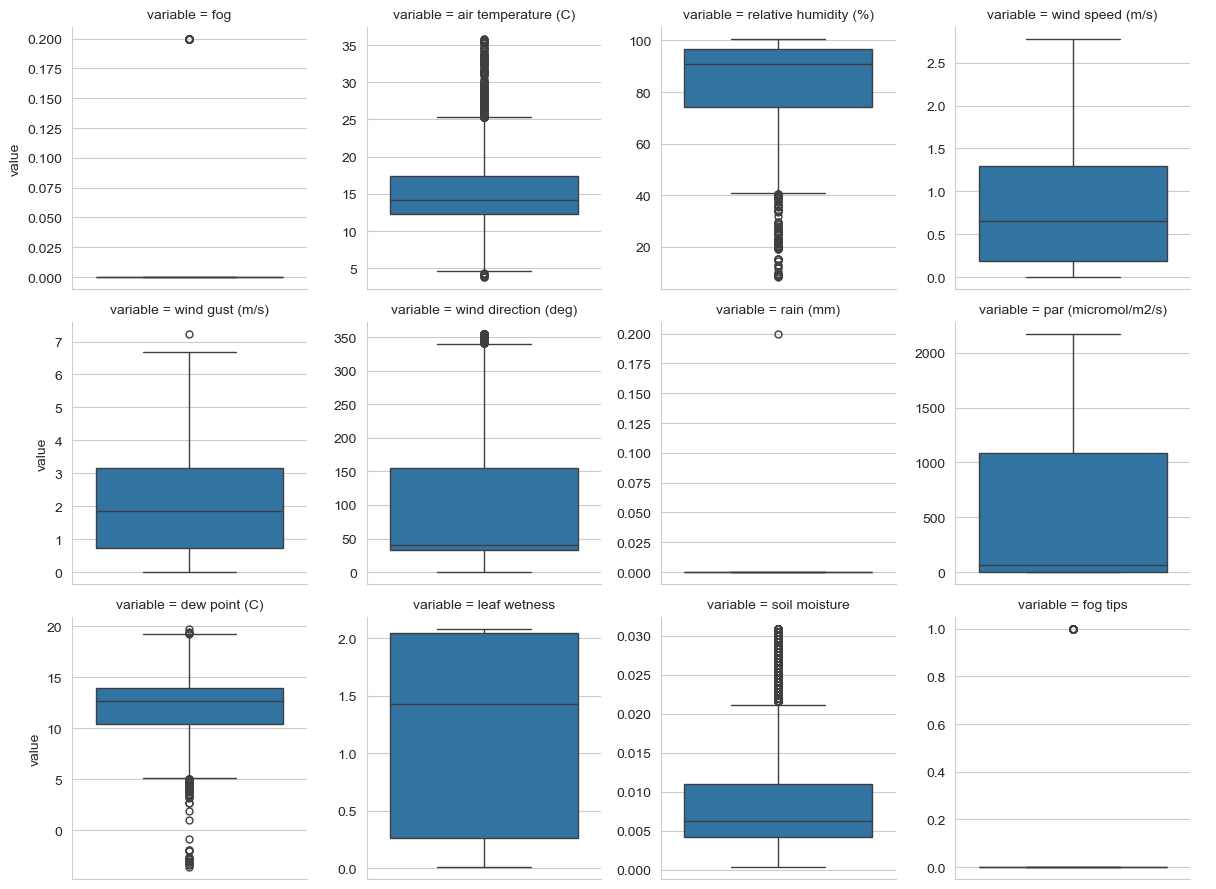

In [92]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [93]:
#### Chekc the actual values ####
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),par (micromol/m2/s),dew point (C),leaf wetness,soil moisture,fog tips
count,15465,15465.000000,13168.000000,13168.000000,7020.000000,7020.000000,7020.000000,15465.000000,15465.000000,13168.000000,15465.000000,15465.000000,15465.00000
mean,2004-06-24 23:30:00,0.000194,14.887231,85.195185,0.802325,1.997772,82.986111,0.000013,492.985580,12.112071,1.200331,0.008266,0.00097
min,2004-04-05 10:30:00,0.000000,3.810000,8.200000,0.000000,0.000000,0.000000,0.000000,1.300000,-3.600000,0.009200,0.000360,0.00000
25%,2004-05-15 17:00:00,0.000000,12.230000,74.199997,0.190000,0.740000,32.299999,0.000000,1.300000,10.400000,0.261800,0.004180,0.00000
50%,2004-06-24 23:30:00,0.000000,14.200000,90.699997,0.650000,1.860000,40.700001,0.000000,61.299999,12.650000,1.430100,0.006300,0.00000
75%,2004-08-04 06:00:00,0.000000,17.450001,96.500000,1.300000,3.150000,155.800000,0.000000,1086.300000,13.940000,2.045300,0.010970,0.00000
max,2004-09-13 12:30:00,0.200000,35.860001,100.700000,2.780000,7.240000,355.200010,0.200000,2173.800000,19.770000,2.081900,0.030900,1.00000
std,NaN,0.006226,4.258841,13.965068,0.719742,1.406986,83.329435,0.001608,702.067347,2.583715,0.815951,0.006130,0.03113


### Constrain RH
Ensure all values are between 0 and 100

In [94]:
df['relative humidity (%)'] = df['relative humidity (%)'].clip(lower=0, upper=100)

### Check leaf wetness values - is there a clear response to moisture? 

<Axes: xlabel='condition', ylabel='leaf wetness'>

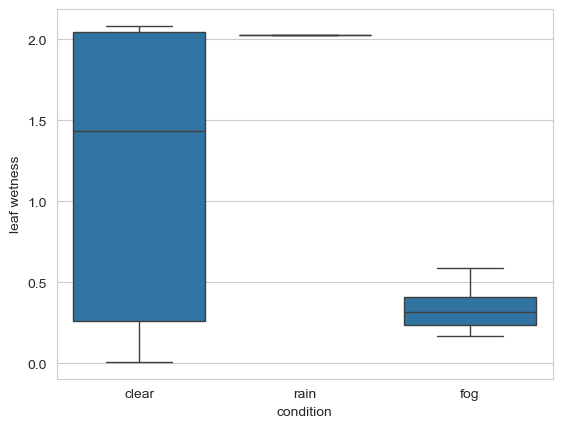

In [95]:
def label_condition(df):
    df['condition'] = 'clear'
    for index, row in df.iterrows():
        condition='clear'
        if row['fog tips'] > 0:
            df.loc[index, 'condition'] = 'fog'

        if row['rain (mm)'] > 0:
            df.loc[index, 'condition'] = 'rain'
        
        if (row['rain (mm)'] > 0) & (row['fog tips'] > 0):
            df.loc[index, 'condition'] = 'both'
    
    return df

tmp = df[['fog tips', 'rain (mm)', 'leaf wetness']].copy()
tmp = label_condition(tmp)

sns.boxplot(data=tmp,
            x='condition',
            y='leaf wetness')

### Save out cleaned data

In [96]:
#### Save out cleaned data ####
df.to_csv(outfpath)
print(outfpath)

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis/data/02-clean/sci-crat-clean.csv
